In [1]:
using CSV, DataFrames, Dates, Plots, DiffEqFlux, DifferentialEquations.OrdinaryDiffEq, Optim, Random

In [2]:
N = 40
tamanho_amostra = 10
UODE_model_name = "SIRD_UODE_b"
cost_name = "SSR-max"
csv_file_name = string("parametros/", UODE_model_name, "/parametros_UODE_", cost_name, "_", N, "_dias.csv")

df = DataFrame(CSV.File("DadosMedia.csv"))

datasTudo = df[:, "DatasMedia"]
infTudo = df[:, "InfectadosMedia"]
recTudo = df[:, "RecuperadosMedia"]
decTudo = df[:, "ObitosMedia"]

limiteE = findall(data -> data == Date(2020, 03, 18), datasTudo)[1]
limiteD = findall(data -> data == Date(2020, 06, 30), datasTudo)[1]

datasOnda = datasTudo[limiteE:limiteD]
infOnda = infTudo[limiteE:limiteD]
recOnda = recTudo[limiteE:limiteD]
decOnda = decTudo[limiteE:limiteD]

dadosOnda = hcat(infOnda, recOnda, decOnda)

u₀  = [infOnda[1], recOnda[1], decOnda[1]]
θ_ext₀_SIR = [50_000, 0.5, 0.5, 0.5]

function dudtSIR!(du, u, θ, t)
    S, I, R, D = u
    N = S + I + R + D
    β, γ_R, γ_D = θ

    E_novos = β^2 * I*S / N
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

indModelo = [2, 3, 4]
iterSIR = 10^4

dadosTreino = dadosOnda[1:N, :]    
dadosTreinoT = dadosTreino'

if cost_name == "SSR-111"
    fator_inf = 1
    fator_rec = 1
    fator_dec = 1
elseif cost_name == "SSR-max"
    fator_inf = 1/sum(abs2, dadosTreinoT[1, :])
    fator_rec = 1/sum(abs2, dadosTreinoT[2, :])
    fator_dec = 1/sum(abs2, dadosTreinoT[3, :])
end

fatores = [fator_inf fator_rec fator_dec]
fatores = fatores / sqrt(sum(abs2, fatores))

1×3 Matrix{Float64}:
 0.00291398  0.0162503  0.999864

In [3]:
# AJUSTE SIR:    
modeloSIR(θ_ext) = solve(ODEProblem(dudtSIR!, [θ_ext[1]; u₀], (1., N), θ_ext[2:end]), saveat = 1)[indModelo, :]

custoSIR(θ_ext) = sum(fatores * (dadosTreinoT .- modeloSIR(θ_ext)) .^2)

θ_ext₁_SIR = Optim.minimizer(optimize(custoSIR, θ_ext₀_SIR, iterations = iterSIR))
S₀ = θ_ext₁_SIR[1]
θ₁_SIR = θ_ext₁_SIR[2:end]

CSV.write(string("parametros/", UODE_model_name, "/condicao_inicial_", cost_name, "_", N, "_dias.csv"),
    DataFrame(permutedims([S₀]), :auto), header = false)
CSV.write(string("parametros/", UODE_model_name, "/parametros_SIRD_", cost_name, "_", N, "_dias.csv"),
    DataFrame(permutedims(θ₁_SIR), :auto), header = false)

"parametros/SIRD_UODE_b/parametros_SIRD_SSR-max_40_dias.csv"

In [ ]:
S₀ = CSV.read(string("parametros/", UODE_model_name, "/condicao_inicial_", cost_name, "_", N, "_dias.csv"), DataFrame,
    header = false)[1, 1]

θ₁_SIR = CSV.read(string("parametros/", UODE_model_name, "/parametros_SIRD_", cost_name, "_", N, "_dias.csv"), DataFrame,
    header = false)[1, :]

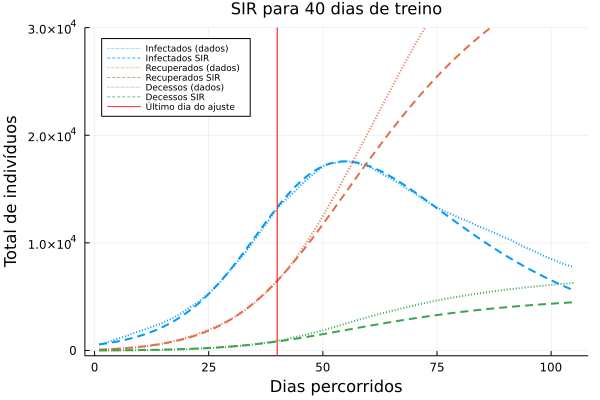

0.9866349127181424

In [4]:
resultSIR = solve(ODEProblem(dudtSIR!, [S₀; u₀], (1., size(dadosOnda)[1]), θ₁_SIR), saveat = 1)

infSIR = resultSIR[indModelo[1], :]
recSIR = resultSIR[indModelo[2], :]
decSIR = resultSIR[indModelo[3], :]

pl = plot(infOnda, label = "Infectados (dados)", lw = 2, color = 1, linestyle = :dot)
plot!(pl, infSIR, label = "Infectados SIR", lw = 2, color = 1, linestyle = :dash)

plot!(pl, recOnda, label = "Recuperados (dados)", lw = 2, color = 2, linestyle = :dot)
plot!(pl, recSIR, label = "Recuperados SIR", lw = 2, color = 2, linestyle = :dash)

plot!(pl, decOnda, label = "Decessos (dados)", lw = 2, color = 3, linestyle = :dot)
plot!(pl, decSIR, label = "Decessos SIR", lw = 2, color = 3, linestyle = :dash)

plot!(pl, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")

plot!(pl, title = "SIR para $N dias de treino", titlefont = 11 , ylim = (-500, 30000),
    xlabel = "Dias percorridos", ylabel = "Total de indivíduos", legend = :topleft, legendfont = 6)

display(pl)

fatorReducao = sum([S₀; u₀])
dadosTreinoT = dadosTreinoT ./ fatorReducao
u₀ = u₀ ./ fatorReducao
S₀ = S₀ / fatorReducao

In [5]:
function ajusteUODE()
    #NN = FastChain(FastDense(2,16,tanh), FastDense(16,16,tanh), FastDense(16,1), (x, θ) -> x.^2)
    NN = FastChain(FastDense(4,16,tanh), FastDense(16,16,tanh), FastDense(16,1), (x, θ) -> x.^2)
    #inputVectorSizeNN = 2
    inputVectorSizeNN = 4
    
    numDataPoints = 1_000
    Xs = rand(inputVectorSizeNN, numDataPoints)

    #func(X) = θ₁_SIR[1]^2 * X[1]*X[2]
    func(X) = θ₁_SIR[1]^2

    data_func = [func(X) for X in eachcol(Xs)]

    function costNN(θ)
        pred = [NN(X, θ)[1] for X in eachcol(Xs)]
        return sum(abs2, data_func .- pred), pred
    end

    resultBFGS = DiffEqFlux.sciml_train(costNN, initial_params(NN), BFGS(initial_stepnorm = 0.01), maxiters = 1_000, 
        allow_f_increases = true)
    θ₀_NN = resultBFGS.minimizer

    #function dudtUODE!(du, u, θ, t)
    #    S, I, R, D = u
    #    N = S + I + R + D
    #    γ_R, γ_D = θ[1:2]
    #
    #    E_novos =  NN([S/N, I], θ[3:end])[1]
    #    dS = -E_novos 
    #    dI = E_novos - (γ_R^2 + γ_D^2)*I
    #    dR = γ_R^2*I
    #    dD = γ_D^2*I
    #
    #    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
    #end
    
    function dudtUODE!(du, u, θ, t)
        S, I, R, D = u
        N = S + I + R + D
        γ_R, γ_D = θ[1:2]
    
        E_novos =  NN(u, θ[3:end])[1] * I*S / N
        dS = -E_novos 
        dI = E_novos - (γ_R^2 + γ_D^2)*I
        dR = γ_R^2*I
        dD = γ_D^2*I
    
        du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
    end

    θ₀_UODE = [θ₁_SIR[2]; θ₁_SIR[3]; θ₀_NN]
    
    problemaUODE = ODEProblem(dudtUODE!, [S₀; u₀], (1.,N), θ₀_UODE)

    function custoUODE(θ)
        previsao = concrete_solve(problemaUODE, Vern7(), [S₀; u₀], θ, saveat = 1, abstol = 1e-4, reltol = 1e-4, sensealg = 
            InterpolatingAdjoint(autojacvec = ReverseDiffVJP()))[indModelo, :]
        custo = sum(fatores * (dadosTreinoT .- previsao) .^2)
        return custo, previsao
    end
    
    costs = []

    function callBackUODE(θ, custo, previsao)
        push!(costs, custo)
        return false
    end

    resultadoBFGS_UODE = DiffEqFlux.sciml_train(custoUODE, θ₀_UODE, cb = callBackUODE, BFGS(initial_stepnorm = 0.01), maxiters =
        250, allow_f_increases = true)

    θ₁_UODE = resultadoBFGS_UODE

    modeloUODE = solve(ODEProblem(dudtUODE!, [S₀; u₀], (1., size(dadosOnda)[1]), θ₁_UODE), saveat = 1)[indModelo, :]' .* 
        fatorReducao

    infUODE = modeloUODE[:, 1]
    recUODE = modeloUODE[:, 2]
    decUODE = modeloUODE[:, 3]

    pl = plot(infOnda, label = "Infectados (dados)", lw = 2, color = 1, linestyle = :dot)
    plot!(pl, infSIR, label = "Infectados SIR", lw = 2, color = 1, linestyle = :dash)
    plot!(pl, infUODE, label = string("Infectados UODE"), lw = 2, color = 1)

    plot!(pl, recOnda, label = "Recuperados (dados)", lw = 2, color = 2, linestyle = :dot)
    plot!(pl, recSIR, label = "Recuperados SIR", lw = 2, color = 2, linestyle = :dash)
    plot!(pl, recUODE, label = string("Recuperados UODE"), lw = 2, color = 2)

    plot!(pl, decOnda, label = "Decessos (dados)", lw = 2, color = 3, linestyle = :dot)
    plot!(pl, decSIR, label = "Decessos SIR", lw = 2, color = 3, linestyle = :dash)
    plot!(pl, decUODE, label = string("Decessos UODE"), lw = 2, color = 3)

    plot!(pl, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")

    plot!(pl, title = string("UODE x SIR para $N dias de treino [custo = ", cost_name, "]"),  titlefont = 11 , ylim = 
        (-500, 50000), xlabel = "Dias percorridos", ylabel = "Total de indivíduos", legend = :topleft, legendfont = 6)

    display(pl)

    CSV.write(csv_file_name, DataFrame(permutedims([θ₁_UODE; costs[end]]), :auto), append = true)
end

ajusteUODE (generic function with 1 method)

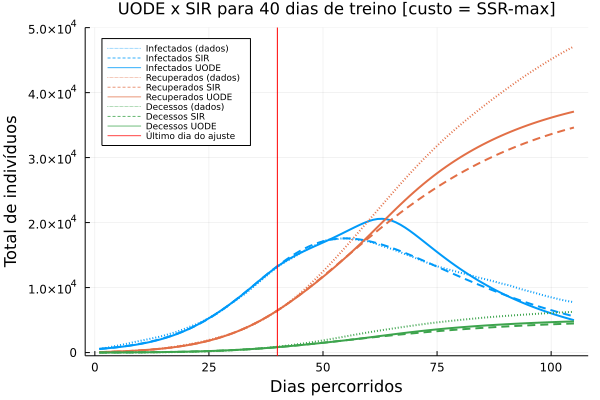

"parametros/SIRD_UODE_b/parametros_UODE_SSR-max_40_dias.csv"

In [6]:
try
    ajusteUODE()
catch
    println("Optimization failed.")
end

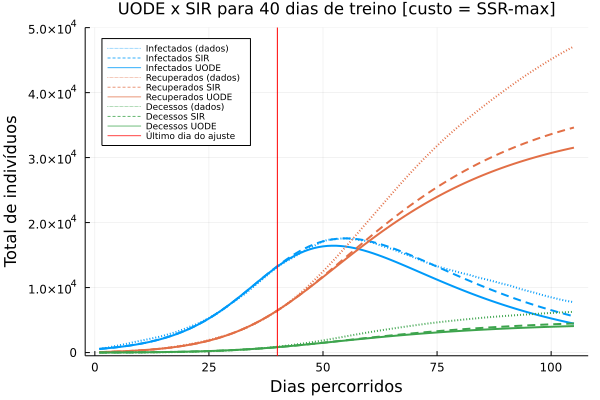

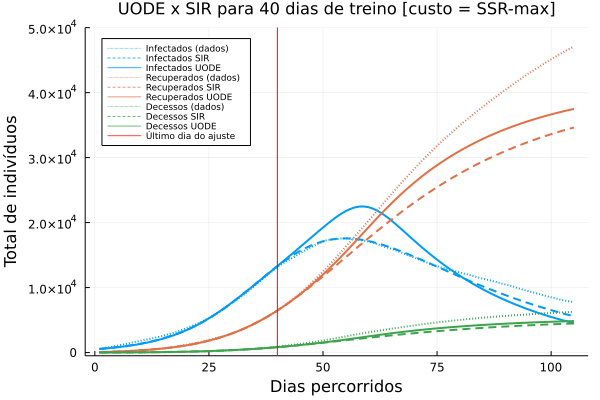

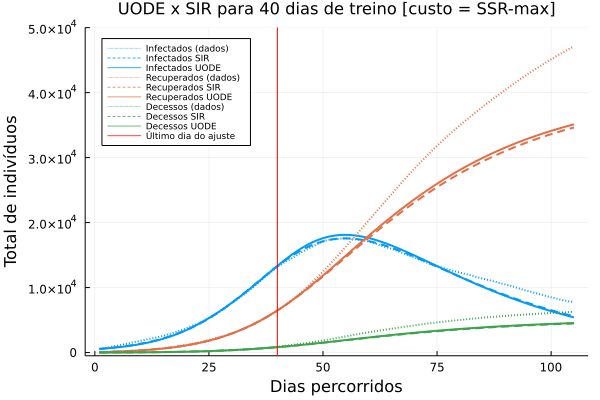

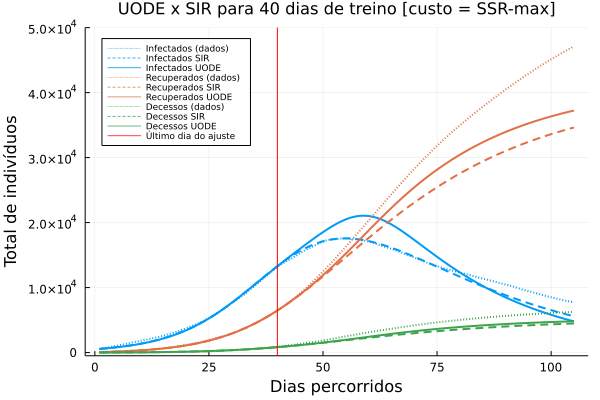

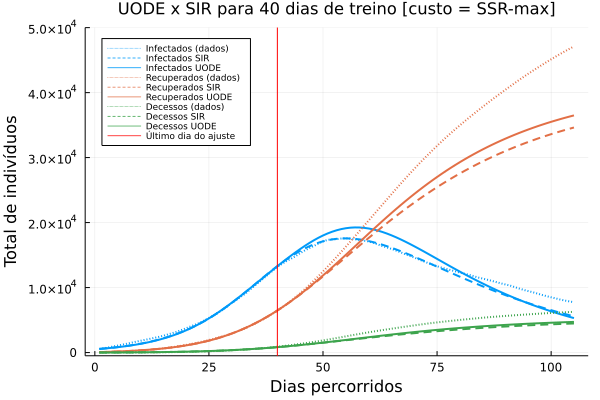

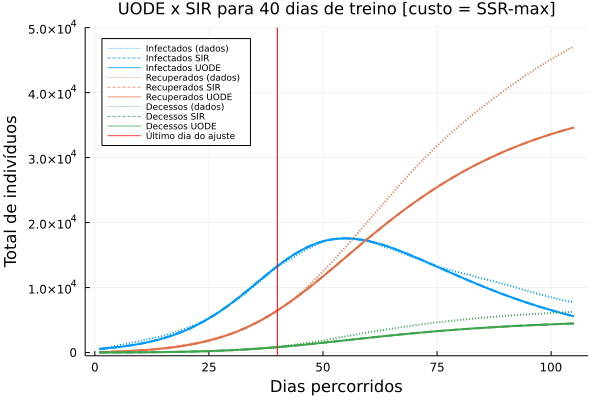

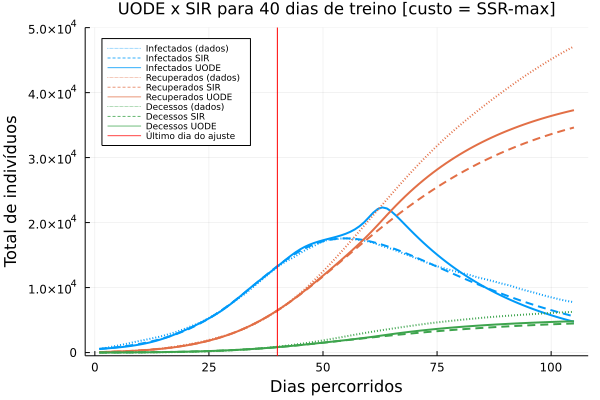

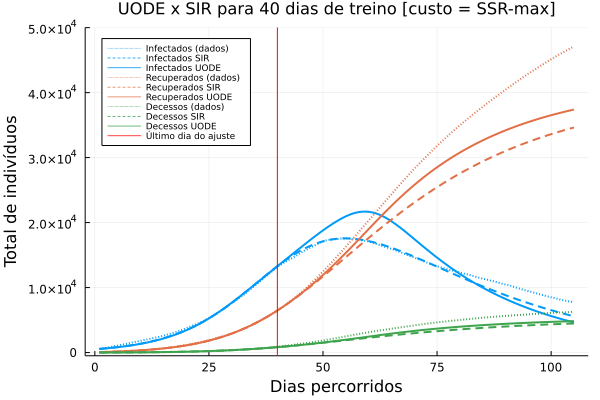

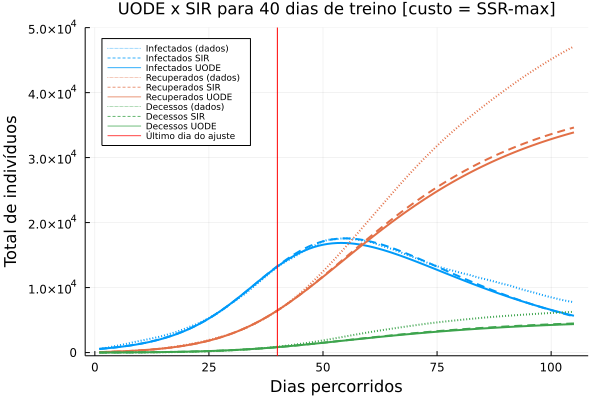

In [7]:
df = CSV.read(csv_file_name, DataFrame, header = false)

while length(df[:, 1]) < tamanho_amostra
    try
        ajusteUODE()
    catch
        println("Optimization failed.")
    end
    df = CSV.read(csv_file_name, DataFrame, header = false)
end